# Entwicklung von KI in der Wissenschaft

- cs.LG
- cs.AI
- cs.CC
- math.ST
- math.OC
- math.PR
- stat.ML
- cs.CV
- cs.CL
- cs.NE
- cs.RO
- math.DS
- cs.HC
- cs.DM
- cs.MA
- cs.SD
- math.QA
- q-fin.ST
- q-fin.MF
- q-fin.CP
- stat.TH

In [264]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import HuberRegressor

## Helper Functions

In [265]:
def plot_with_spline(df, title, period):
    df["period"] = df["published_date"].dt.to_period(period)
    papers_per_period = df.groupby("period").size().reset_index(name="count")
    papers_per_period["period"] = papers_per_period["period"].dt.to_timestamp()

    # Convert datetime to numeric for spline fitting
    x = (
        papers_per_period["period"].astype("int64")
    )  # Convert to seconds since epoch
    y = papers_per_period["count"]

    # Fit a smooth spline
    spline = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    x_smooth = np.linspace(x.min(), x.max(), 7)
    y_smooth = spline(x_smooth)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Scatter plot on the first chart
    sns.scatterplot(data=papers_per_period, x="period", y="count", ax=ax1, label="Data")
    ax1.plot(
        pd.to_datetime(x_smooth, unit="ns"),
        y_smooth,
        color="red",
        linewidth=3,  # Make line thicker
        label="Smooth Line (Spline)",
    )
    ax1.set_xlabel("Period")
    ax1.set_ylabel("Number of Papers")
    ax1.set_title(title + " (Original Scale)")
    ax1.legend()

    # Scatter plot on the second chart with logarithmic scale
    sns.scatterplot(data=papers_per_period, x="period", y="count", ax=ax2, label="Data")
    ax2.plot(
        pd.to_datetime(x_smooth, unit="ns"),
        y_smooth,
        color="red",
        linewidth=3,  # Make line thicker
        label="Smooth Line (Spline)",
    )
    ax2.set_yscale('log')
    ax2.set_xlabel("Period")
    ax2.set_ylabel("Number of Papers (Log Scale)")
    ax2.set_title(title + " (Logarithmic Scale)")
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Data

In [266]:
df = pd.read_csv("arxiv_papers.csv")
df

,paper_id,published_date,categories,id
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.AI,9401101v1
1,http://arxiv.org/abs/hep-th/9401023v1,1994-01-06,"hep-th,math.QA",9401023v1
2,http://arxiv.org/abs/hep-th/9401016v1,1994-01-06,"hep-th,math.QA",9401016v1
3,http://arxiv.org/abs/math/9401224v1,1994-01-12,math.DS,9401224v1
4,http://arxiv.org/abs/hep-th/9401050v1,1994-01-12,"hep-th,math.QA",9401050v1
...,...,...,...,...
635245,http://arxiv.org/abs/2412.18204v1,2024-12-24,cs.CV,2412.18204v1
635246,http://arxiv.org/abs/2412.18202v1,2024-12-24,"cs.LG,q-fin.ST",2412.18202v1
635247,http://arxiv.org/abs/2412.18201v1,2024-12-24,"math.OC,math.CV,math.FA,q-fin.PM,q-fin.PR,30C1...",2412.18201v1
635248,http://arxiv.org/abs/2412.18215v1,2024-12-24,"math.OC,math.PR",2412.18215v1


In [267]:
df.tail(5)

,paper_id,published_date,categories,id
635245,http://arxiv.org/abs/2412.18204v1,2024-12-24,cs.CV,2412.18204v1
635246,http://arxiv.org/abs/2412.18202v1,2024-12-24,"cs.LG,q-fin.ST",2412.18202v1
635247,http://arxiv.org/abs/2412.18201v1,2024-12-24,"math.OC,math.CV,math.FA,q-fin.PM,q-fin.PR,30C1...",2412.18201v1
635248,http://arxiv.org/abs/2412.18215v1,2024-12-24,"math.OC,math.PR",2412.18215v1
635249,http://arxiv.org/abs/2412.18123v1,2024-12-24,"cs.CR,cs.CL",2412.18123v1


In [268]:
df = df[df["id"].str.endswith("v1")]
df

,paper_id,published_date,categories,id
0,http://arxiv.org/abs/cs/9401101v1,1994-01-01,cs.AI,9401101v1
1,http://arxiv.org/abs/hep-th/9401023v1,1994-01-06,"hep-th,math.QA",9401023v1
2,http://arxiv.org/abs/hep-th/9401016v1,1994-01-06,"hep-th,math.QA",9401016v1
3,http://arxiv.org/abs/math/9401224v1,1994-01-12,math.DS,9401224v1
4,http://arxiv.org/abs/hep-th/9401050v1,1994-01-12,"hep-th,math.QA",9401050v1
...,...,...,...,...
635245,http://arxiv.org/abs/2412.18204v1,2024-12-24,cs.CV,2412.18204v1
635246,http://arxiv.org/abs/2412.18202v1,2024-12-24,"cs.LG,q-fin.ST",2412.18202v1
635247,http://arxiv.org/abs/2412.18201v1,2024-12-24,"math.OC,math.CV,math.FA,q-fin.PM,q-fin.PR,30C1...",2412.18201v1
635248,http://arxiv.org/abs/2412.18215v1,2024-12-24,"math.OC,math.PR",2412.18215v1


These categories can be used in search queries to filter relevant papers.

- cs.LG: Machine Learning
- cs.AI: Artificial Intelligence
- stat.ML: Statistics > Machine Learning
- cs.NE: Neural and Evolutionary Computing
- cs.CL: Computation and Language
- cs.CV: Computer Vision and Pattern Recognition
- cs.RO: Robotics

In [269]:
df["published_date"] = pd.to_datetime(df["published_date"])

C:\Users\Niklas\AppData\Local\Temp\ipykernel_2584\355913404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["published_date"] = pd.to_datetime(df["published_date"])


## Visualization

### Allgemeine Entwicklung

C:\Users\Niklas\AppData\Local\Temp\ipykernel_2584\4016581403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["period"] = df["published_date"].dt.to_period(period)


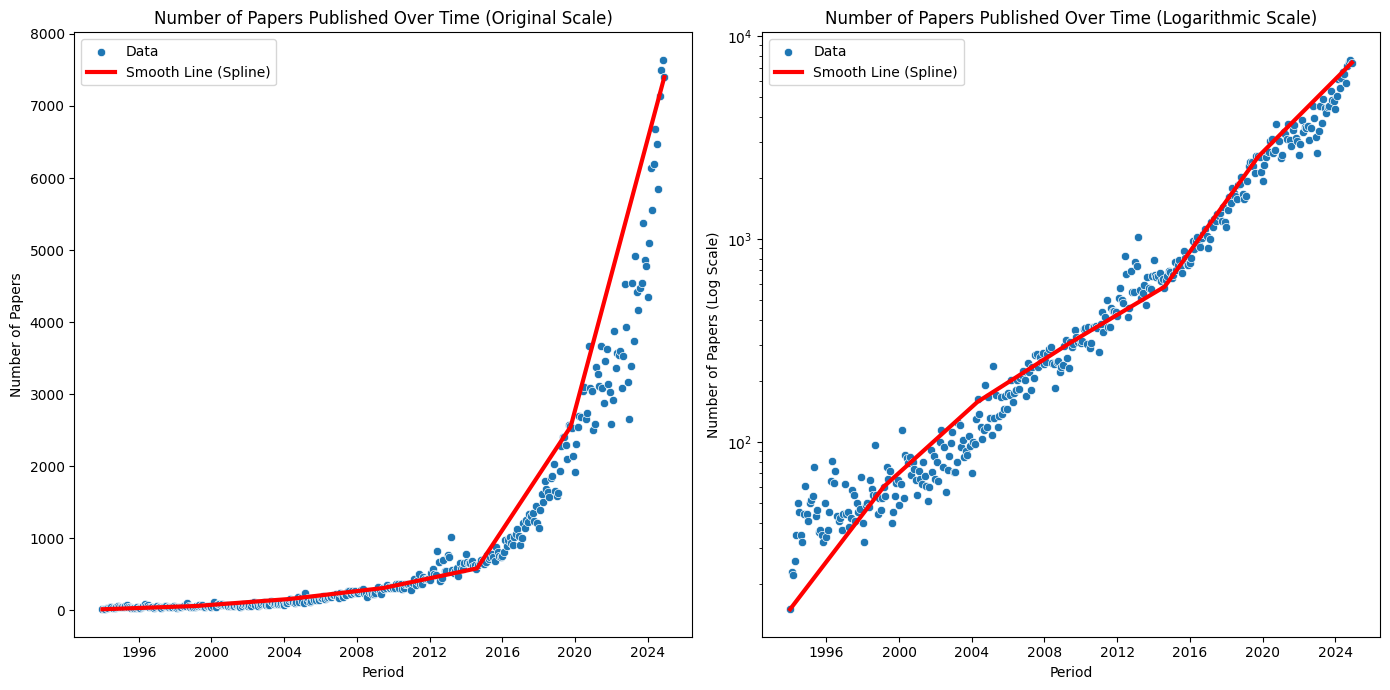

In [270]:
plot_with_spline(df, "Number of Papers Published Over Time", "M")

C:\Users\Niklas\AppData\Local\Temp\ipykernel_2584\4016581403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["period"] = df["published_date"].dt.to_period(period)


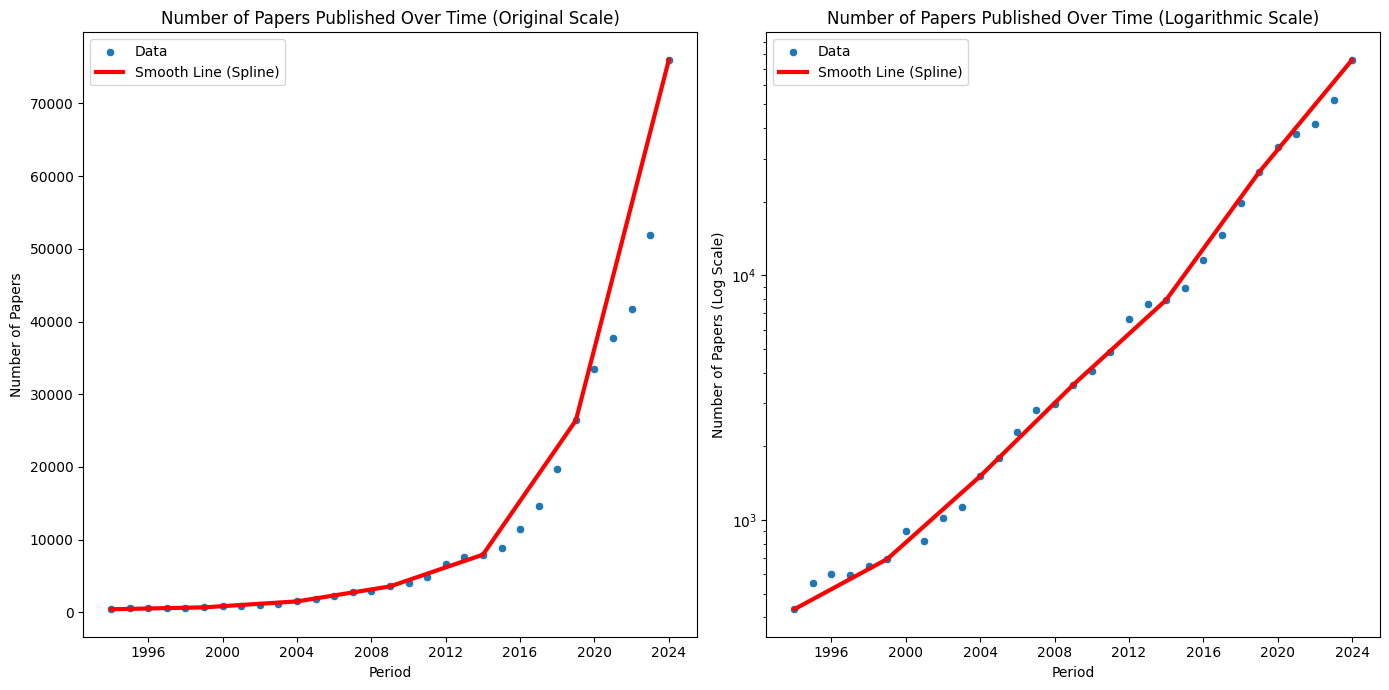

In [271]:
plot_with_spline(df, "Number of Papers Published Over Time", "Y")

### Nach Kategorien

In [272]:
categories = [
    "cs.lg",
    "cs.ai",
    "cs.cc",
    "math.st",
    "math.oc",
    "math.pr",
    "stat.ml",
    "cs.cv",
    "cs.cl",
    "cs.ne",
    "cs.ro",
    "math.ds",
    "cs.hc",
    "cs.dm",
    "cs.ma",
    "cs.sd",
    "math.qa",
    "q-fin.st",
    "q-fin.mf",
    "q-fin.cp",
    "stat.th"
]

In [273]:
period = 1
df["period"] = df["published_date"].dt.year

df['categories'] = df['categories'].str.lower().str.split(',')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

df_filtered = df[df['categories'].isin(categories)]

counts = df_filtered.groupby(['categories', "period"]).size().reset_index(name='count')

C:\Users\Niklas\AppData\Local\Temp\ipykernel_2584\935213496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["period"] = df["published_date"].dt.year
C:\Users\Niklas\AppData\Local\Temp\ipykernel_2584\935213496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categories'] = df['categories'].str.lower().str.split(',')


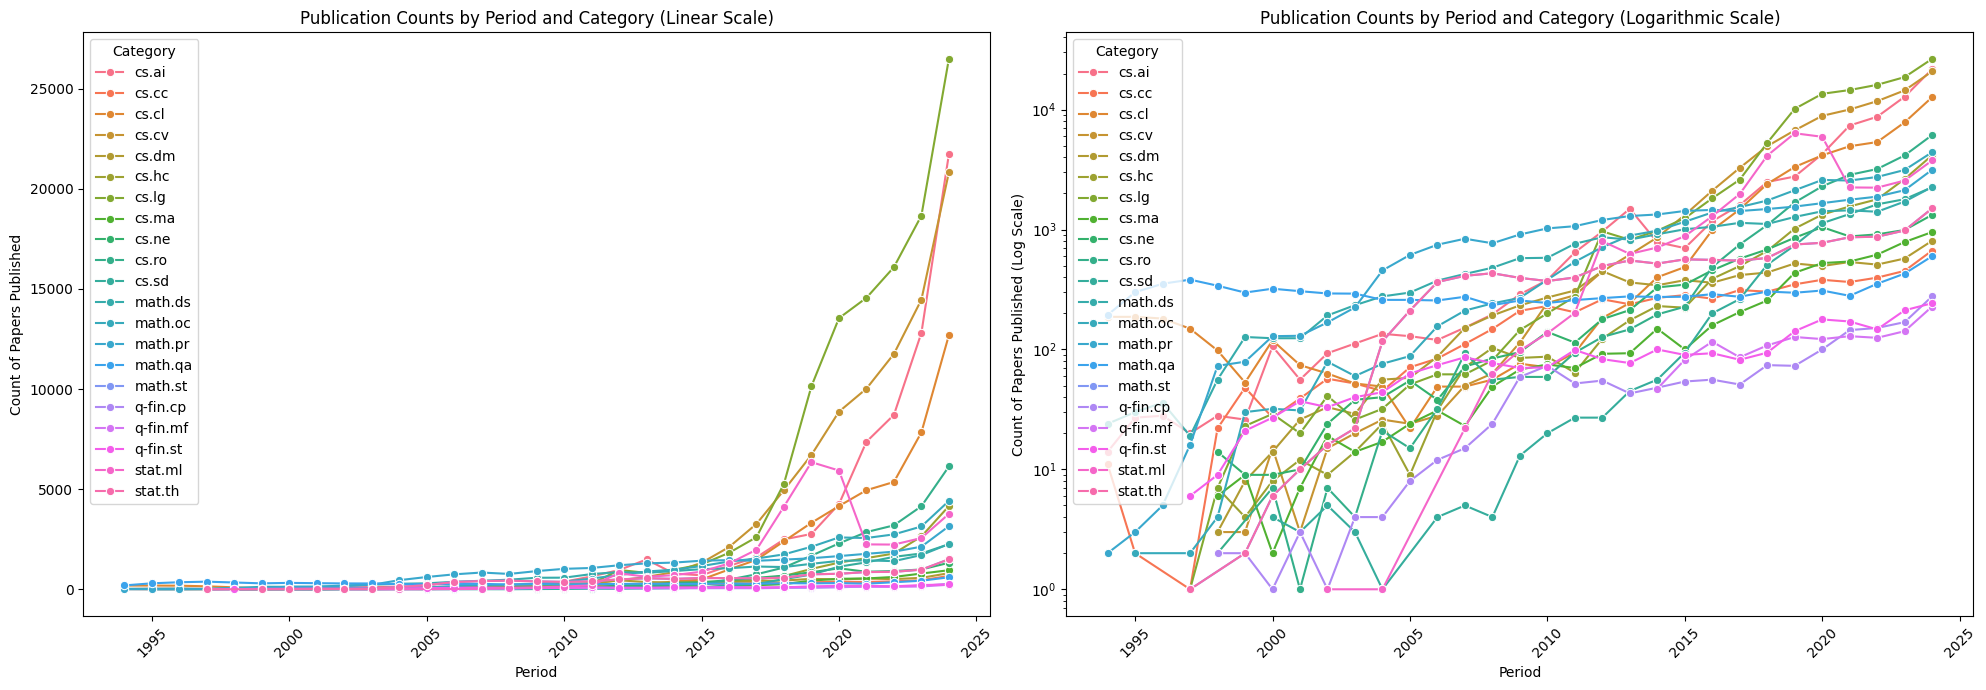

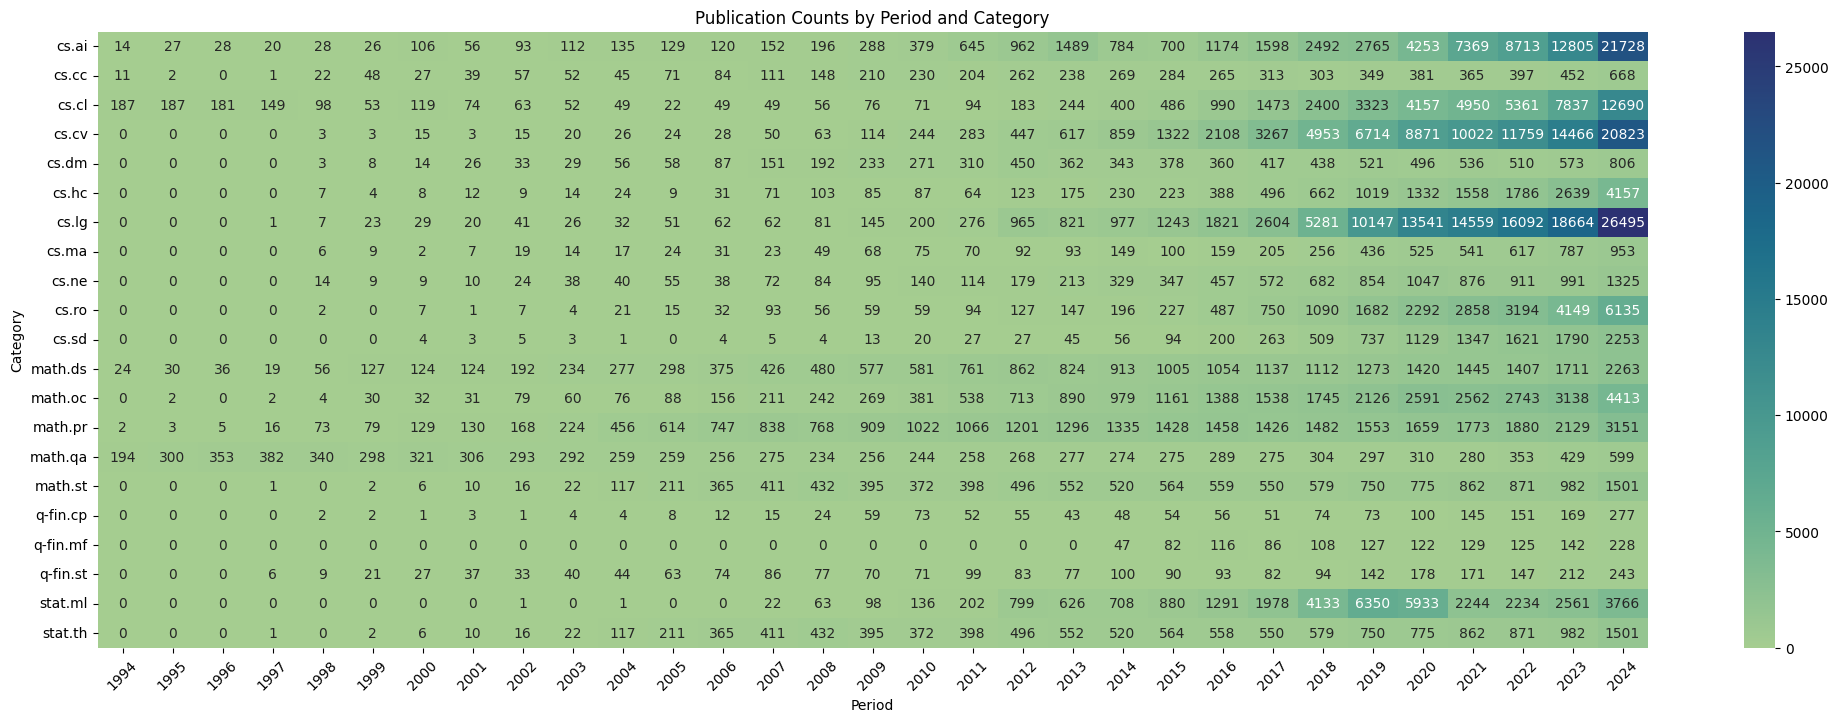

In [274]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.lineplot(data=counts, x='period', y='count', hue='categories', marker='o', ax=ax1)
ax1.set_title("Publication Counts by Period and Category (Linear Scale)")
ax1.set_xlabel("Period")
ax1.set_ylabel("Count of Papers Published")
ax1.legend(title='Category')
ax1.tick_params(axis='x', rotation=45)

sns.lineplot(data=counts, x='period', y='count', hue='categories', marker='o', ax=ax2)
ax2.set_yscale('log')
ax2.set_title("Publication Counts by Period and Category (Logarithmic Scale)")
ax2.set_xlabel("Period")
ax2.set_ylabel("Count of Papers Published (Log Scale)")
ax2.legend(title='Category')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

df['categories'] = df['categories'].str.lower().str.split(',')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

df_filtered = df[df['categories'].isin(categories)]

counts = df_filtered.groupby(['categories', "period"]).size().unstack(fill_value=0)

plt.figure(figsize=(25, 8)) 
sns.heatmap(counts, annot=True, fmt="d", cmap="crest")
plt.title("Publication Counts by Period and Category")
plt.xlabel("Period")
plt.xticks(rotation=45)
plt.ylabel("Category")
plt.yticks(rotation=0)
plt.show()


#### Normalized

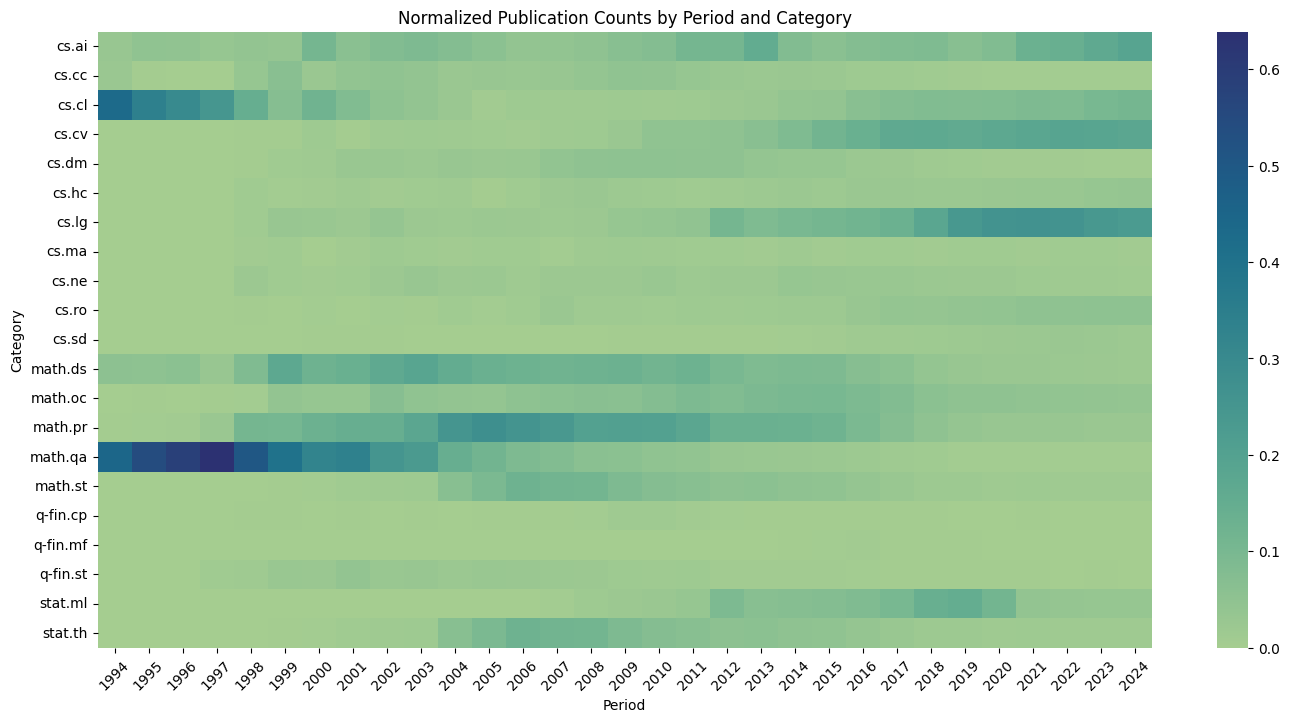

In [276]:
period = 1
df["period"] = df["published_date"].dt.year

df['categories'] = df['categories'].str.lower().str.split(',')
df = df.explode('categories')
df['categories'] = df['categories'].str.strip()

df_filtered = df[df['categories'].isin(categories)]

counts = df_filtered.groupby(['categories', "period"]).size().reset_index(name='count')

pivot_counts = counts.pivot(index="categories", columns="period", values="count").fillna(0)

normalized_counts = pivot_counts.div(pivot_counts.sum(axis=0), axis=1)

plt.figure(figsize=(17, 8))
sns.heatmap(normalized_counts, annot=False, fmt=".2f", cmap="crest")
plt.title("Normalized Publication Counts by Period and Category")
plt.xlabel("Period")
plt.xticks(rotation=45)
plt.ylabel("Category")
plt.yticks(rotation=0)
plt.show()